In this notebook, I predict the BitCoin (BTC) high value (the highest value of the currency in a given minute) by training a Recurrent Neural Network based on LSTM on a recent CryptoCurrency TimeSeries dataset.

Dataset link:  https://www.kaggle.com/roopahegde/cryptocurrency-timeseries-2020

References:
https://colah.github.io/posts/2015-08-Understanding-LSTMs/
<br/>
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
<br/>
https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
<br/>
https://www.kaggle.com/charel/learn-by-example-rnn-lstm-gru-time-series
<br/>
https://www.datacamp.com/community/tutorials/lstm-python-stock-market

In [19]:
# Importing the requried packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [20]:
# Loading the CSV file and sorting based on date
dataset = pd.read_csv('gemini_BTCUSD_2020_1min.csv', index_col='Date', parse_dates=['Date'])
dataset = dataset.sort_values('Date')
dataset['Mid'] = (dataset['Low'] + dataset['High'])/2.0
dataset.head()


,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,Mid
Date,,,,,,,,
2020-01-01 00:00:00,1.577840e+12,BTCUSD,7165.9,7170.79,7163.3,7163.3,0.007931,7167.045
2020-01-01 00:01:00,1.577840e+12,BTCUSD,7163.3,7164.23,7163.3,7163.3,0.002646,7163.765
2020-01-01 00:02:00,1.577840e+12,BTCUSD,7163.3,7164.22,7163.0,7163.0,0.063904,7163.610
2020-01-01 00:03:00,1.577840e+12,BTCUSD,7163.0,7163.60,7163.0,7163.6,0.002706,7163.300
2020-01-01 00:04:00,1.577840e+12,BTCUSD,7163.6,7163.60,7163.0,7163.0,1.751844,7163.300


In [21]:
# Setting the parameters for the model.
# size: the total amount of data used for training and testing
# test_split_percentage: determines the fraction of data used for testing
# seq_size: the sequence size for creating the dataset
# batch_size: the batch size used for training
# epochs: number of epochs for training
size = dataset.shape[0]
test_split_percentage = 5
seq_size = 60
batch_size = 32
epochs = 2
n_ranges_for_normalize = 100


In [22]:
# extracting the values from the dataframe to create the training and test splits.
# averaging High and Low to create Mid
test_set_size = int((size*test_split_percentage)/100)
training_inputs = dataset['Mid'].iloc[:size-test_set_size].to_frame()
test_inputs_for_plot = dataset['Mid'].iloc[size-test_set_size:size].to_frame()

# adding a "seq_size" batch of data prior to the start of test split, to predict the first batch of test set
test_inputs = dataset['Mid'].iloc[size-test_set_size-seq_size:size].to_frame()

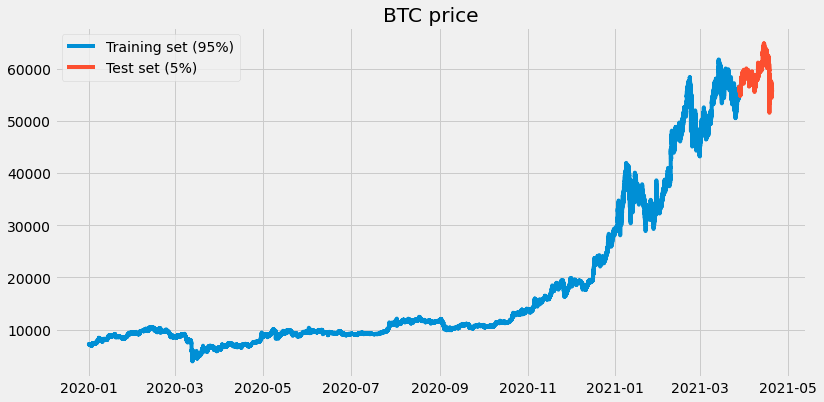

In [23]:
# plotting the training and test splits
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(training_inputs)
ax.plot(test_inputs_for_plot)
plt.legend(['Training set (95%)','Test set (5%)'])
plt.title('BTC price')
plt.show()





In [24]:
# dividing the training data into regions,
# and scaling the regions individually and finally the test values to the range [0,1]
training_size = training_inputs.shape[0]
window_size = int(training_size/n_ranges_for_normalize)
sc = MinMaxScaler(feature_range=(0,1))

for i in range(0,training_size,window_size):
    training_inputs[i:i+window_size] = sc.fit_transform(training_inputs[i:i+window_size])

if training_size > i+window_size:
    training_inputs[i+window_size:] = sc.fit_transform(training_inputs[i+window_size:])

test_inputs = sc.fit_transform(test_inputs)

In [25]:
# now let's apply exponential smoothing to remove the noise and make a smoother curve

exp_avg = 0.0
gamma = 0.1
for i in range(training_inputs.shape[0]):
  exp_avg = gamma*training_inputs['Mid'][i] + (1-gamma)*exp_avg
  training_inputs['Mid'][i] = exp_avg





In [26]:
# creating the input and output (X and Y) for training the RNN. Every batch of "seq_size" values create a single X value, and the first value after that batch, creates a single Y value.
X_train = []
y_train = []
for i in range(seq_size,training_inputs.shape[0]):
    X_train.append(training_inputs[i-seq_size:i])
    y_train.append(training_inputs[i:i+1])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping the X values as per Keras requirements
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

# creating the input (X) for the test set in a similar way.
X_test = []
for i in range(seq_size,test_inputs.shape[0]):
    X_test.append(test_inputs[i-seq_size:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [27]:
y_train = np.reshape(y_train, (y_train.shape[0],1))

In [28]:
# defining the RNN model. This network contains 4 LSTM units with dropout layers in between (to regularize the training and avoid overfitting). There is a single number as the output of the network (the prediction).
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer ='rmsprop', loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train, y_train, epochs=2, batch_size=batch_size)

Epoch 1/2
625102/625102 [==============================] - 6839s 11ms/sample - loss: 0.0012
Epoch 2/2
625102/625102 [==============================] - 6833s 11ms/sample - loss: 6.2909e-04


In [29]:
# Making predictions based on the test set and scaling back from [0,1] to the actual values.
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

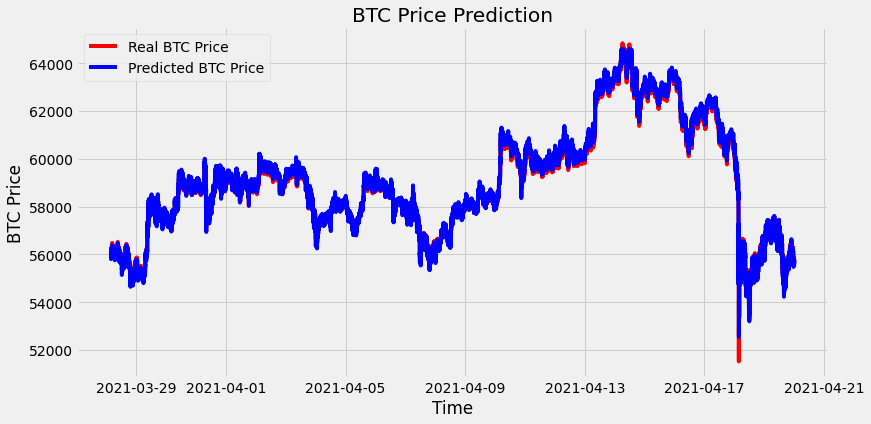

In [30]:
# plotting the predictions vs. the actual prices
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(test_inputs_for_plot.index,test_inputs_for_plot.values, color='red',label='Real BTC Price')
ax.plot(test_inputs_for_plot.index, predicted_stock_price, color='blue',label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

In [31]:
# calculating the Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(test_inputs_for_plot, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))


The root mean squared error is 138.32899221184513.
